# 3. GloVe: Global Vectors for Word Representation

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture3.pdf
* https://nlp.stanford.edu/pubs/glove.pdf

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
print(torch.__version__)
print(nltk.__version__)

0.2.0+1449c2c
3.2.4


In [3]:
USE_CUDA = torch.cuda.is_available()

In [4]:
def getBatch(batch_size,train_data):
    random.shuffle(train_data)
    sindex=0
    eindex=batch_size
    while eindex < len(train_data):
        batch = train_data[sindex:eindex]
        temp = eindex
        eindex = eindex+batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [5]:
def make_vocab_vector(vocab, word2index):
    idxs = list(map(lambda w: word2index[w] if w in word2index.keys() else word2index["<UNK>"], vocab))
    tensor = Variable(torch.LongTensor(idxs)).cuda() if USE_CUDA else  Variable(torch.LongTensor(idxs))
    return tensor

def make_input_vector(input,word2index):
    tensor = Variable(torch.LongTensor([word2index[input]]) if input in word2index.keys() else torch.LongTensor([word2index["<UNK>"]]))
    if USE_CUDA:
        tensor = tensor.cuda()
    return tensor

#make_input_vector(train_data[0][1], word2index)

## Load corpus : CoNLL 2000 corpus

If you don't have gutenberg corpus, you can download it first using nltk.download()

In [6]:
nltk.corpus.conll2000.fileids()

['train.txt', 'test.txt']

In [34]:
corpus = list(nltk.corpus.conll2000.sents('train.txt'))[:1000]
corpus = [[word.lower() for word in sent] for sent in corpus]

In [35]:
len(corpus)

1000

### Prepare train data 

In [36]:
vocab = list(set(flatten(corpus)))

In [37]:
word2index={}
for vo in vocab:
    if vo not in word2index.keys():
        word2index[vo]=len(word2index)
        
index2word={v:k for k,v in word2index.items()}

In [38]:
WINDOW_SIZE = 5
windows =  flatten([list(nltk.ngrams(['<DUMMY>']*WINDOW_SIZE+c+['<DUMMY>']*WINDOW_SIZE,WINDOW_SIZE*2+1)) for c in corpus])

window_data = []

for window in windows:
    for i in range(WINDOW_SIZE*2+1):
        if i==WINDOW_SIZE or window[i]=='<DUMMY>': continue
        window_data.append((window[WINDOW_SIZE],window[i]))


### Build Co-occurence Matrix X

In [39]:
X_i = Counter(flatten(corpus)) # X_i

In [40]:
X_ik_window_5 = Counter(window_data) # Co-occurece in window size 5

In [41]:
X_ik={}

Because of model complexity, It is important to determine whether a tighter bound can be placed on the number of nonzero elements of X.

In [42]:
for vi in vocab:
    for vk in vocab:
        target = (vi,vk)
        if target in X_ik_window_5.keys(): # nonzero elements
            co_occer = X_ik_window_5[target]
            X_ik[target]=co_occer+1 # log(Xik) -> log(Xik+1) to prevent divergence
        else:
            #X_ik[target]=1
            continue

In [43]:
test = random.choice(window_data)
print(test)
print(X_ik[(test[0],test[1])]==X_ik[(test[1],test[0])])

('postponed', 'was')
True


### Weighting Function 

In [44]:
def weighting(w_i,w_j):
    x_ij = X_ik[(w_i,w_j)]
    x_max = 20 #100 # fixed in paper
    alpha = 0.75
    
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1
    
    return result

In [45]:
weighting_dic={}

In [46]:
for bigram in X_ik.keys():
    weighting_dic[bigram] = weighting(bigram[0],bigram[1])

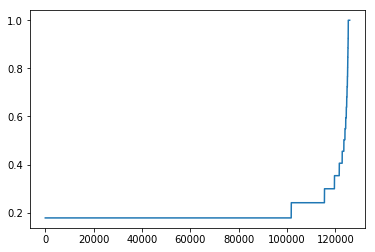

In [47]:
dist = sorted(weighting_dic.items(),key=lambda x:x[1])
x,y = list(zip(*dist))
plt.plot(y)

In [48]:
len(X_ik) # < O(|V^2|) 

125922

### make train set 

In [49]:
u_p=[] # center vec
v_p=[] # context vec
co_p=[] # log(x_ij)
weight_p=[] # f(x_ij)

for bigram in X_ik.keys():
    temp = make_input_vector(bigram[0],word2index)
    u_p.append(temp.view(1,-1))
    temp = make_input_vector(bigram[1],word2index)
    v_p.append(temp.view(1,-1))
    temp = torch.log(Variable(torch.Tensor([X_ik[bigram]]))).cuda if USE_CUDA else torch.log(Variable(torch.Tensor([X_ik[bigram]])))
    co_p.append(temp.view(1,-1))
    temp = Variable(torch.Tensor([weighting_dic[bigram]])).cuda() if USE_CUDA else Variable(torch.Tensor([weighting_dic[bigram]]))
    weight_p.append(temp.view(1,-1))
    
train_data = list(zip(u_p,v_p,co_p,weight_p))
print(train_data[0])

(Variable containing:
 370
[torch.LongTensor of size 1x1]
, Variable containing:
 466
[torch.LongTensor of size 1x1]
, Variable containing:
 1.0986
[torch.FloatTensor of size 1x1]
, Variable containing:
 0.2410
[torch.FloatTensor of size 1x1]
)


### Modeling 

In [50]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,projection_dim):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
                
        initrange = (2.0 / (vocab_size+projection_dim))**0.5 # Xavier init
        self.embedding_v.weight.data.uniform_(-initrange, initrange) # init
        self.embedding_u.weight.data.uniform_(-initrange, initrange) # init
        
    def forward(self, inputs,targets,coocs,weights):
        center_embeds = self.embedding_v(inputs) # B x 1 x D
        context_embeds = self.embedding_u(targets) # B x 1 x D
        
        inner_product = center_embeds.bmm(context_embeds.transpose(1,2)).squeeze(1) # Bx1
        
        loss = weights*torch.pow(inner_product - coocs,2)
        
        return torch.sum(loss)
    
    def prediction(self, inputs):
        v_embeds = self.embedding_v(inputs) # B x 1 x D
        u_embeds = self.embedding_u(inputs) # B x 1 x D
                
        return v_embeds+u_embeds # final embed

### Train 

In [83]:
PROJECTION = 30 # Embedding size
BATCH_SIZE = 128
STEP_SIZE = 50

In [84]:
losses = []
model = GloVe(len(word2index),PROJECTION)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [85]:
for step in range(STEP_SIZE):
    for i,batch in enumerate(getBatch(BATCH_SIZE,train_data)):
        
        inputs, targets, coocs, weights = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        coocs = torch.cat(coocs)
        weights = torch.cat(weights)
        model.zero_grad()

        loss = model(inputs,targets,coocs,weights)
        
        loss.backward()
        optimizer.step()
    
        losses.append(loss.data.cpu().numpy()[0] if USE_CUDA else loss.data.numpy()[0])
    if step % 10==0:
        print("Step : %d, mean_loss : %.02f" % (step,np.mean(losses)))
        losses=[]

Step : 0, mean_loss : 21.69
Step : 10, mean_loss : 2.74
Step : 20, mean_loss : 0.98
Step : 30, mean_loss : 0.41
Step : 40, mean_loss : 0.27


### Test 

In [27]:
from scipy.spatial.distance import euclidean, cosine

In [28]:
def word_similarity(target,vocab):
    if USE_CUDA:
        target_V = model.prediction(make_input_vector(target,word2index)).data.cpu().numpy()
    else:
        target_V = model.prediction(make_input_vector(target,word2index)).data.numpy()
    similarities=[]
    for i in range(len(vocab)):
        if vocab[i] == target: continue
        
        if USE_CUDA:
            vector = model.prediction(make_input_vector(list(vocab)[i],word2index)).data.cpu().numpy()
        else:
            vector = model.prediction(make_input_vector(list(vocab)[i],word2index)).data.numpy()
        #similarity.append([vocabs[i],np.dot(target_V,vector.T)[0][0]])
        similarities.append([vocab[i],cosine(target_V,vector)])
     
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

In [99]:
test = random.choice(list(vocab))
test

'averting'

In [100]:
word_similarity(test,vocab)

[['executive', 0.78251637923175421],
 ['chairman', 0.77359353009598197],
 ['$', 0.76923143782682346],
 ['says', 0.76916210677722097],
 ['president', 0.76859034807543569],
 ['officer', 0.76680730233479522],
 ['million', 0.74787895400607818],
 ['chief', 0.74098626311970417],
 ['second', 0.72979793001086635],
 ['share', 0.71937666743762385]]

# TODO 

* 이게 제대로 짠건지 검증을 못하겠네... 어케하지?
* model complexity 부분 좀 더 보기... 
* CoNLL-2003으로..